In [1]:
!pip install transformers scikit-learn torch
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 12.9 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm.notebook import tqdm
import random
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import contractions
from wordcloud import WordCloud
import logging
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from tqdm.notebook import tqdm
import sys
import os
import contextlib
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("transformers").setLevel(logging.WARNING)

In [7]:
import logging
logging.getLogger("transformers").setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore')

DATA_PATH = '/content/Combined Data.csv' # Replace with your actual path
TEXT_COLUMN = 'statement'
LABEL_COLUMN = 'status'

# Data Splitting
TEST_SIZE = 0.2             # Proportion of data for the final test set
VALIDATION_SPLIT_SIZE = 0.1 # Proportion of the initial training data to use for validation (DL model)

# Baseline Model (Logistic Regression)
N_SPLITS_CV_BASELINE = 3    # Number of K-Fold splits for GridSearchCV for Logistic Regression
MAX_FEATURES_TFIDF = 5000   # Max features for TF-IDF

# Deep Learning Model (RoBERTa)
MODEL_NAME_DL = 'roberta-base'
MAX_LEN_DL = 160
BATCH_SIZE_DL = 16 # Reminder: If CUDA OOM, reduce to 8 or 4.
EPOCHS_DL = 7 # epochs
LEARNING_RATE_DL = 2e-5
WEIGHT_DECAY_DL = 0.01 # weight decay for regularization
DROPOUT_RATE_DL = 0.2 # custom dropout rate (default is often 0.1)
PATIENCE_EPOCHS = 2 # patience for earlier stopping if overfitting

# Text Preprocessing
MIN_WORDS_AFTER_CLEANING = 5   # Minimum words a text must have after cleaning to be kept


In [8]:
nlp = None         # spaCy language model instance
stop_words = set() # Set of stopwords
lemmatizer = None  # NLTK Lemmatizer instance

try:
    # Attempt to download NLTK resources. raise_on_error=True will stop if download fails.
    nltk.download('wordnet', quiet=True, raise_on_error=True)
    nltk.download('stopwords', quiet=True, raise_on_error=True)
    nltk.download('punkt', quiet=True, raise_on_error=True)
    # averaged_perceptron_tagger might be needed by some advanced lemmatizers or POS taggers.
    # nltk.download('averaged_perceptron_tagger', quiet=True, raise_on_error=True)

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    _ = lemmatizer.lemmatize("test") # Dummy call to ensure WordNet is properly loaded
    print("NLTK resources (stopwords, wordnet) loaded successfully.")
except Exception as e:
    print(f"NLTK resource download or initialization error: {e}.")
    print("Stopword removal or NLTK Lemmatization might be affected or skipped.")

try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model 'en_core_web_sm' loaded successfully.")
except Exception as e:
    print(f"spaCy model ('en_core_web_sm') loading error: {e}. spaCy-based lemmatization will not be available.")
    nlp = None # Ensure nlp is None if loading fails

NLTK resources (stopwords, wordnet) loaded successfully.
spaCy model 'en_core_web_sm' loaded successfully.


In [9]:
print("\n Data Loading...")
data = pd.read_csv(DATA_PATH)
df = data.copy()


 Data Loading...


In [10]:
print("\n📊 DATASET OVERVIEW")
print("-" * 30)

print(f"Dataset Shape: {df.shape}")
print(f"Total Entries: {len(df)}")
print(f"Columns: {list(df.columns)}")


📊 DATASET OVERVIEW
------------------------------
Dataset Shape: (53043, 3)
Total Entries: 53043
Columns: ['Unnamed: 0', 'statement', 'status']


In [11]:
print("Original dataset shape:", df.shape)
print("\nMissing values before cleaning:")
print(df.isnull().sum())

Original dataset shape: (53043, 3)

Missing values before cleaning:
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [12]:
df_clean = df.dropna(subset=['statement'])

# Initial Split

In [14]:
# Clean column names (e.g., remove leading/trailing spaces)
df.columns = df.columns.str.strip()

if 'Unnamed: 0' in df.columns: # Remove common index column from CSVs
    df = df.drop('Unnamed: 0', axis=1)

# Ensure text and label columns exist
if TEXT_COLUMN not in df.columns or LABEL_COLUMN not in df.columns:
    sys.exit(f"Critical Error: Text column ('{TEXT_COLUMN}') or Label column ('{LABEL_COLUMN}') not found in the data.")

df[TEXT_COLUMN] = df[TEXT_COLUMN].astype(str).fillna('') # Convert text to string, fill NaNs
df = df.dropna(subset=[LABEL_COLUMN]) # Remove rows where the label itself is NaN
df[LABEL_COLUMN] = df[LABEL_COLUMN].astype(str) # Convert labels to string

unique_labels = sorted(df[LABEL_COLUMN].unique().tolist())
if not unique_labels:
    sys.exit(f"Critical Error: No unique labels found in column '{LABEL_COLUMN}' after processing. Please check your data.")

label_map = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_map.items()}
df['label_id'] = df[LABEL_COLUMN].map(label_map) # Create integer labels
print(f"Found {len(unique_labels)} unique labels: {unique_labels}")
print(f"Label map: {label_map}")

X = df[TEXT_COLUMN] # Features
y = df['label_id']  # Target

if len(y.unique()) < 2: # Need at least two classes for classification
    sys.exit("Critical Error: Not enough unique classes in the label column for training (need at least 2).")

# Initial split into training and test sets
try:
    X_train_full, X_test_raw, y_train_full, y_test_raw = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=42, stratify=y
    )
except ValueError: # Fallback if stratification fails (e.g., a class has < 2 members for splitting)
    print("Warning: Stratification failed for initial train/test split. Proceeding without stratification.")
    X_train_full, X_test_raw, y_train_full, y_test_raw = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=42
    )

print(f"Initial full training set size: {len(X_train_full)}, Raw test set size: {len(X_test_raw)}")
print("Data Loading and Initial Splitting Complete.")

Found 7 unique labels: ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']
Label map: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}
Initial full training set size: 42434, Raw test set size: 10609
Data Loading and Initial Splitting Complete.


# Advance Text Process Pipeline

In [16]:
# Note on Word2Vec: Transformer models like RoBERTa learn their own contextual embeddings from scratch during pre-training and fine-tuning.

print("\n Starting Text Preprocessing...")

def expand_contractions_text(text_input):
    if not isinstance(text_input, str): return ""
    return contractions.fix(text_input)

def replace_urls_mentions_hashtags(text_input): # Expanded to handle hashtags
    if not isinstance(text_input, str): return ""
    text_output = re.sub(r'http\S+|www\S+|https\S+', '¡url¿', text_input, flags=re.MULTILINE)
    text_output = re.sub(r'@\w+', '¡user¿', text_output)
    text_output = re.sub(r'#\w+', '¡hashtag¿', text_output) # Replace hashtags with a token
    return text_output

def reduce_repeated_characters(text_input):
    if not isinstance(text_input, str): return ""
    # Replace 3 or more consecutive identical characters with two of that character
    return re.sub(r'(.)\1{2,}', r'\1\1', text_input)

ACRONYM_DICT = {  # Expanded dictionary
    "lol": "laugh out loud", "brb": "be right back", "imo": "in my opinion", "idk": "i do not know",
    "tbh": "to be honest", "omg": "oh my god", "btw": "by the way", "fyi": "for your information",
    "imho": "in my humble opinion", "afaik": "as far as i know", "asap": "as soon as possible", "ttyl": "talk to you later",
    "gr8": "great", "l8r": "later", "w8": "wait", "hbd": "happy birthday", "smh": "shaking my head", "rofl": "rolling on the floor laughing",
    "bff": "best friends forever", "irl": "in real life", "jk": "just kidding", "np": "no problem", "nvm": "never mind", "wtf": "what the f***",
    "wth": "what the hell", "dm": "direct message", "ikr": "i know right", "ily": "i love you", "ilysm": "i love you so much", "omw": "on my way",
    "bc": "because", "bday": "birthday", "thx": "thanks", "ty": "thank you", "yw": "you are welcome", "gg": "good game",
    "idc": "i do not care", "g2g": "got to go", "atm": "at the moment", "tmi": "too much information", "ftw": "for the win",
    "lmao": "laughing my ass off", "afk": "away from keyboard", "xoxo": "hugs and kisses",
    # Mental health & emotion-related
    "mh": "mental health", "ocd": "obsessive compulsive disorder", "ptsd": "post traumatic stress disorder",
    "adhd": "attention deficit hyperactivity disorder", "bpd": "borderline personality disorder", "ed": "eating disorder",
    "su": "suicidal", "numb": "emotionally unresponsive", "anx": "anxiety", "depr": "depression", "stfu": "shut the f*** up",
    "fml": "f*** my life", "idwt": "i do not want to", "imsu": "i am suicidal",
    # Sentiment-heavy shorthand
    "ugh": "expression of frustration", "yay": "expression of joy", "meh": "expression of indifference",
    "sry": "sorry", "pls": "please", "plz": "please", "grrr": "expression of anger", "hugs": "virtual hugs",
    "rip": "rest in peace", "sadface": "sad face", "smile": "smiling face"
}

def expand_acronyms_global(text_input):
    if not isinstance(text_input, str): return ""
    words = text_input.split()
    expanded_words = [ACRONYM_DICT.get(word.lower(), word) for word in words]
    return " ".join(expanded_words)

DIGIT_WORD_REPLACEMENTS_GLOBAL = {"gr8": "great", "l8r": "later", "w8": "wait", "2day": "today", "4u": "for you", "b4": "before"}
def handle_words_with_digits_global(text_input):
    if not isinstance(text_input, str): return ""
    words = text_input.split()
    handled_words = []
    for word in words:
        if word.lower() in DIGIT_WORD_REPLACEMENTS_GLOBAL:
            handled_words.append(DIGIT_WORD_REPLACEMENTS_GLOBAL[word.lower()])
        elif word.isdigit():
            continue
        else: # Remove digits within other words, e.g., "word123" -> "word"
            handled_words.append(re.sub(r'\d', '', word))
    # Filter out empty strings that might result from digit removal (e.g., if a word was purely digits)
    return " ".join(w for w in handled_words if w)

def remove_stopwords_global(text_input):
    if not isinstance(text_input, str) or not stop_words: # Check global stop_words set
        return text_input
    words = text_input.split()
    # Filter out stopwords and any empty strings that might have resulted from previous steps
    filtered_words = [word for word in words if word.lower() not in stop_words and word]
    return " ".join(filtered_words)

def lemmatize_text_global(text_input):
    if not isinstance(text_input, str): return text_input.lower() # Fallback to lowercase
    # Prefer spaCy for potentially more accurate lemmatization due to POS tagging
    if nlp:
        doc = nlp(text_input)
        # spaCy's -PRON- lemma for pronouns; keep them or map them to a generic pronoun token if desired
        return " ".join([token.lemma_.lower() for token in doc if token.lemma_ not in ['-PRON-']])
    elif lemmatizer: # Fallback to NLTK WordNetLemmatizer
        words = nltk.word_tokenize(text_input) # NLTK lemmatizer often works better on tokenized input
        return " ".join([lemmatizer.lemmatize(word).lower() for word in words])
    return text_input.lower() # Final fallback if no lemmatizer is available

def clean_text_series(input_text_series):
    """Applies the full cleaning pipeline to a pandas Series of texts."""
    cleaned_texts_list = []
    # tqdm description reflects the input Series being processed
    for current_text in tqdm(input_text_series, desc=f"Cleaning Text Data ({input_text_series.name if hasattr(input_text_series, 'name') else 'Series'})"):
        t = str(current_text) # Ensure string type
        t = expand_contractions_text(t)
        t = t.lower() # Convert to lowercase early for consistent matching
        t = replace_urls_mentions_hashtags(t) # Handle URLs, mentions, hashtags
        t = expand_acronyms_global(t)
        t = handle_words_with_digits_global(t)
        t = reduce_repeated_characters(t)
        # Remove special characters, keeping letters, numbers, spaces, and our specific tokens (¡url¿, ¡user¿, ¡hashtag¿)
        t = re.sub(r'[^a-z0-9\s¡¿]', '', t)
        # Optional: Stopword removal and Lemmatization. Transformers can often handle these,
        # but for very noisy text, they can still be beneficial.
        t = remove_stopwords_global(t)
        t = lemmatize_text_global(t)
        t = re.sub(r'\s+', ' ', t).strip() # Normalize multiple spaces to single, strip leading/trailing
        cleaned_texts_list.append(t)
    return pd.Series(cleaned_texts_list, index=input_text_series.index)

# Apply cleaning to training and test sets
X_train_cleaned = clean_text_series(X_train_full)
X_test_cleaned = clean_text_series(X_test_raw) # Corrected: Use X_test_raw here

print("\n Text Preprocessing Pipeline Applied.")
if not X_train_cleaned.empty:
    print("Sample cleaned training data:\n", X_train_cleaned.head())

# Filter texts that are too short AFTER cleaning
print(f"\nFiltering texts with fewer than {MIN_WORDS_AFTER_CLEANING} words remaining...")

train_word_counts = X_train_cleaned.apply(lambda x: len(x.split()) if isinstance(x, str) and x.strip() else 0)
valid_train_mask = train_word_counts >= MIN_WORDS_AFTER_CLEANING
X_train_cleaned = X_train_cleaned[valid_train_mask]
y_train_cleaned = y_train_full.loc[valid_train_mask] # Ensure labels are filtered consistently using .loc
print(f"Dropped {sum(~valid_train_mask)} training texts. Remaining training samples: {len(X_train_cleaned)}")

if not X_test_cleaned.empty: # Only filter test set if it's not already empty
    test_word_counts = X_test_cleaned.apply(lambda x: len(x.split()) if isinstance(x, str) and x.strip() else 0)
    valid_test_mask = test_word_counts >= MIN_WORDS_AFTER_CLEANING
    X_test_cleaned = X_test_cleaned[valid_test_mask]
    y_test_cleaned = y_test_raw.loc[valid_test_mask] # Filter corresponding test labels
    print(f"Dropped {sum(~valid_test_mask)} testing texts. Remaining test samples: {len(X_test_cleaned)}")
else:
    y_test_cleaned = pd.Series(dtype=y_test_raw.dtype) # Ensure y_test_cleaned exists as empty if X_test_cleaned is empty

# Critical check: Ensure training data is still available
if X_train_cleaned.empty or y_train_cleaned.empty:
    sys.exit("Critical Error: No training data remains after cleaning and filtering. Halting execution.")
if len(y_train_cleaned.unique()) < 2:
    sys.exit("Critical Error: Less than two unique classes in cleaned training labels. Halting execution.")

print("\n Label distribution in final cleaned training data:")
print(y_train_cleaned.map(id_to_label).value_counts(normalize=True) * 100) # Show percentages

if X_test_cleaned.empty and not X_test_raw.empty: # If test set became empty after filtering
    print("Warning: All test data was filtered out. Test set evaluation will not be meaningful.")
print("Advanced Preprocessing and Filtering Finished.")


 Starting Text Preprocessing...


Cleaning Text Data (statement):   0%|          | 0/42434 [00:00<?, ?it/s]

Cleaning Text Data (statement):   0%|          | 0/10609 [00:00<?, ?it/s]


 Text Preprocessing Pipeline Applied.
Sample cleaned training data:
 37382    r tired suppose get procrastinating damn hate ...
22590    please make pain stop cry hour straight thing ...
38010    lot depressed people barely hold little anythi...
39050    sure belong get take get yr ago go visit frien...
21565    gram prozac save go take alcohol sleep pill ho...
dtype: object

Filtering texts with fewer than 5 words remaining...
Dropped 6477 training texts. Remaining training samples: 35957
Dropped 1605 testing texts. Remaining test samples: 9004

 Label distribution in final cleaned training data:
label_id
Depression              33.765331
Suicidal                23.202714
Normal                  20.780377
Anxiety                  7.965069
Bipolar                  6.160136
Stress                   5.737409
Personality disorder     2.388965
Name: proportion, dtype: float64
Advanced Preprocessing and Filtering Finished.


# EDA Visualization


 Exploratory Data Analysis on Cleaned Training Data


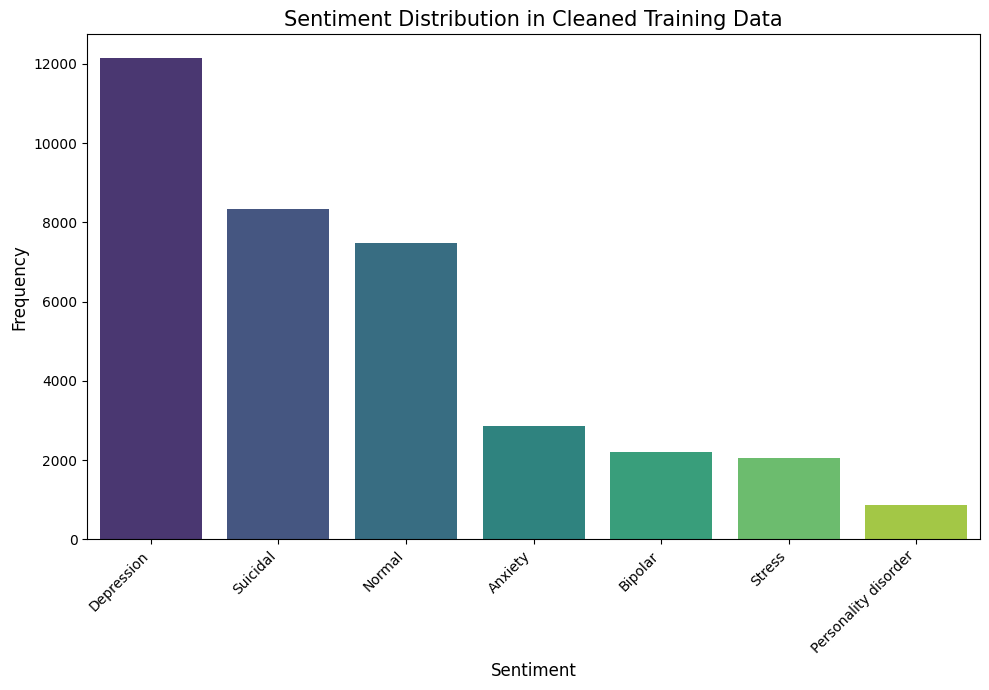

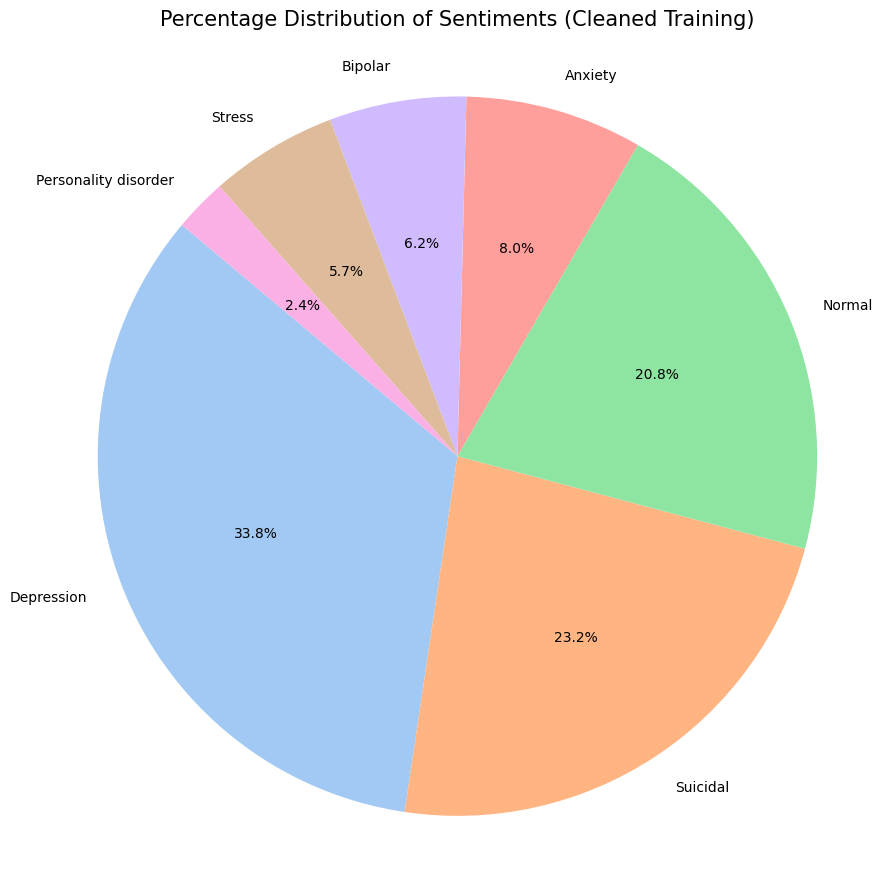

In [19]:
print("\n Exploratory Data Analysis on Cleaned Training Data")
# Sentiment Frequency Bar Chart
if not y_train_cleaned.empty:
    plt.figure(figsize=(10, 7))
    sentiment_counts_train = y_train_cleaned.map(id_to_label).value_counts()
    sns.barplot(x=sentiment_counts_train.index, y=sentiment_counts_train.values, palette="viridis")
    plt.title('Sentiment Distribution in Cleaned Training Data', fontsize=15)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel('Sentiment', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Sentiment Frequency Pie Chart
    plt.figure(figsize=(9, 9))
    plt.pie(sentiment_counts_train, labels=sentiment_counts_train.index, autopct='%1.1f%%',
            startangle=140, colors=sns.color_palette('pastel'), textprops={'fontsize': 10})
    plt.title('Percentage Distribution of Sentiments (Cleaned Training)', fontsize=15)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

## Word Cloud for each sentiment


 Generating Word Clouds for each sentiment class...


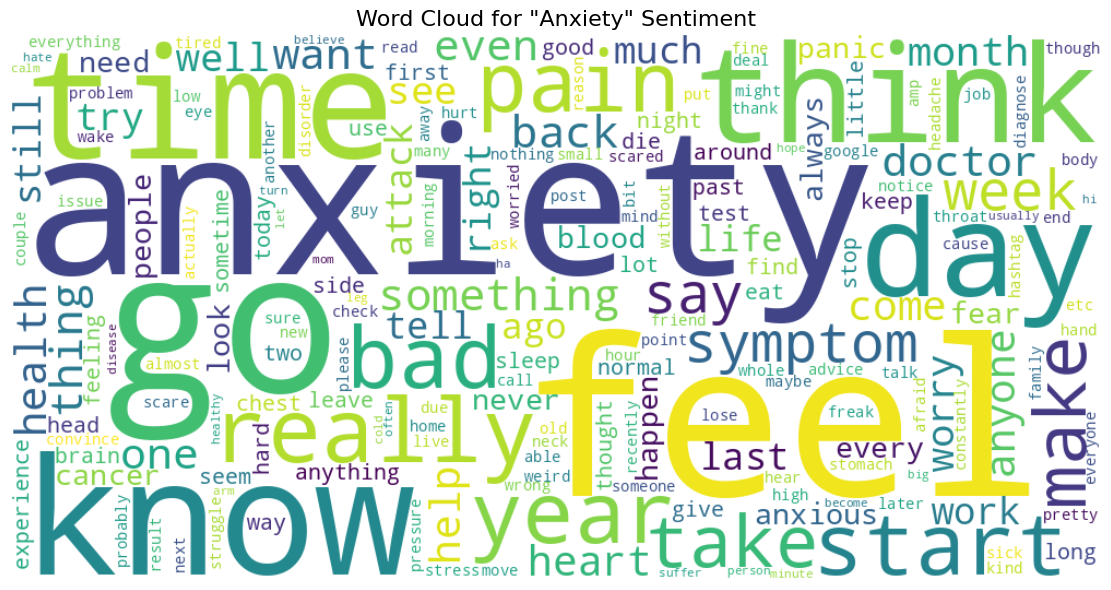

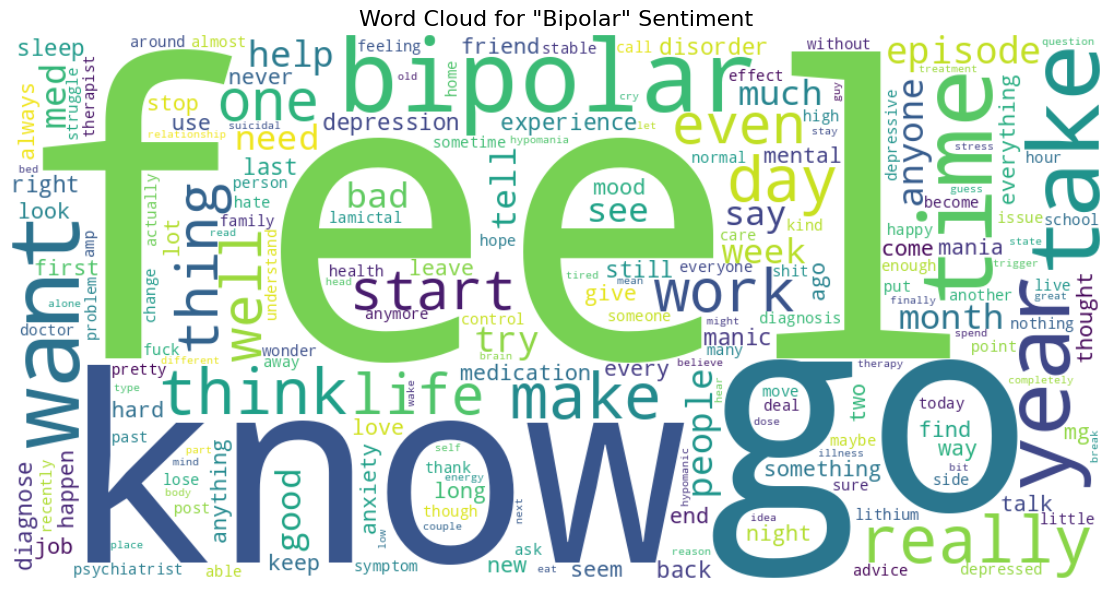

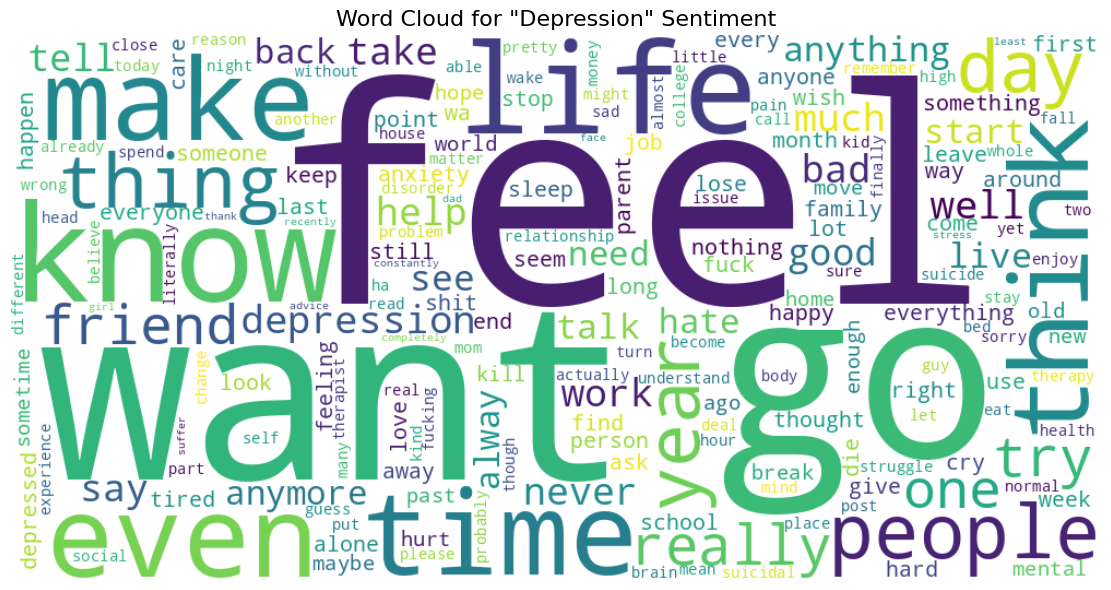

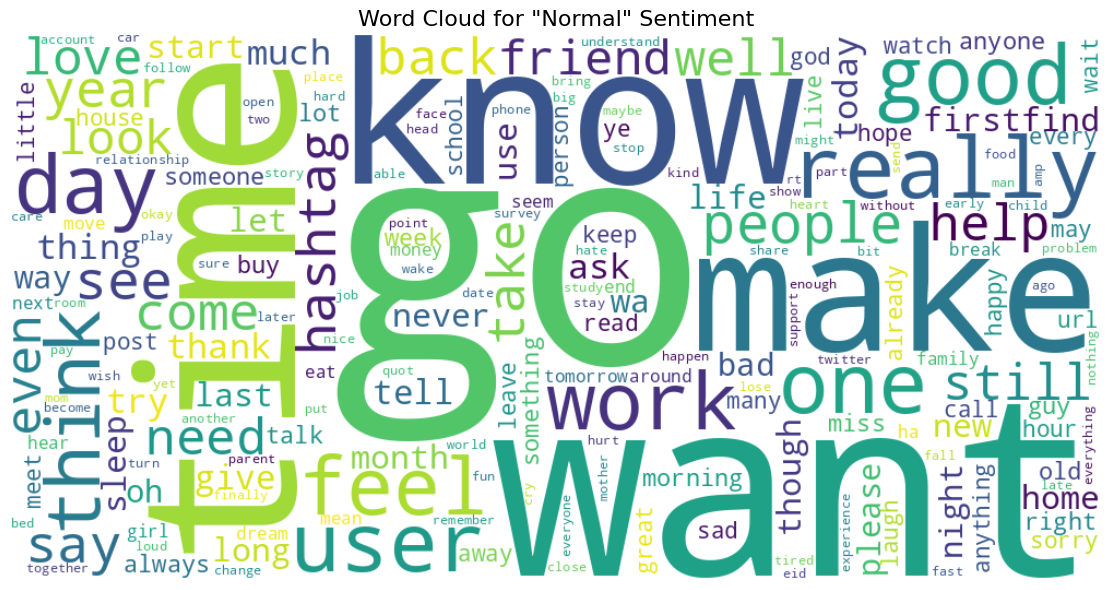

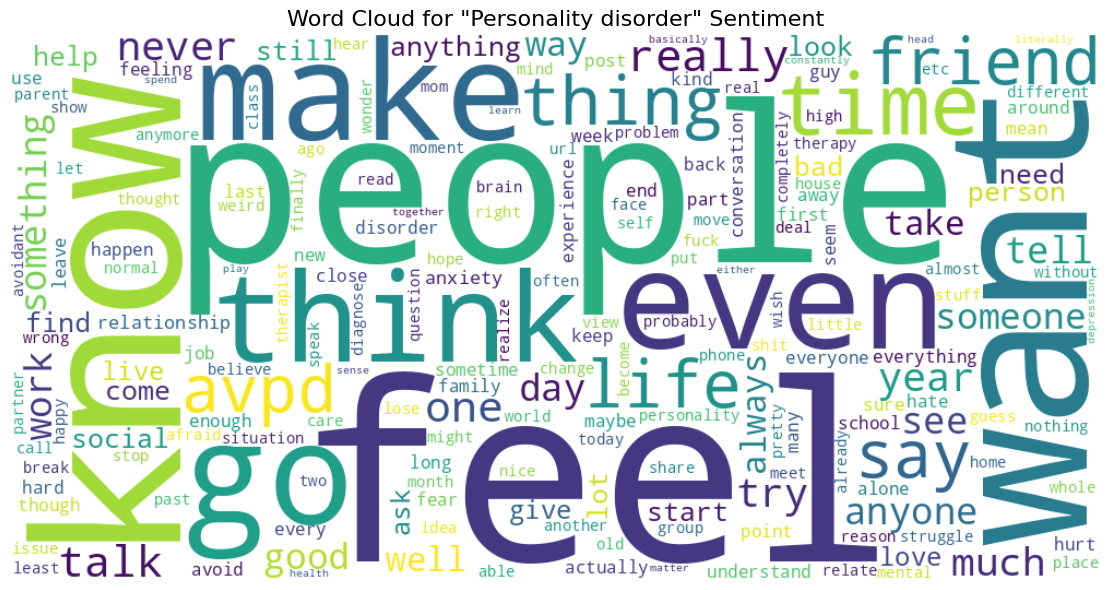

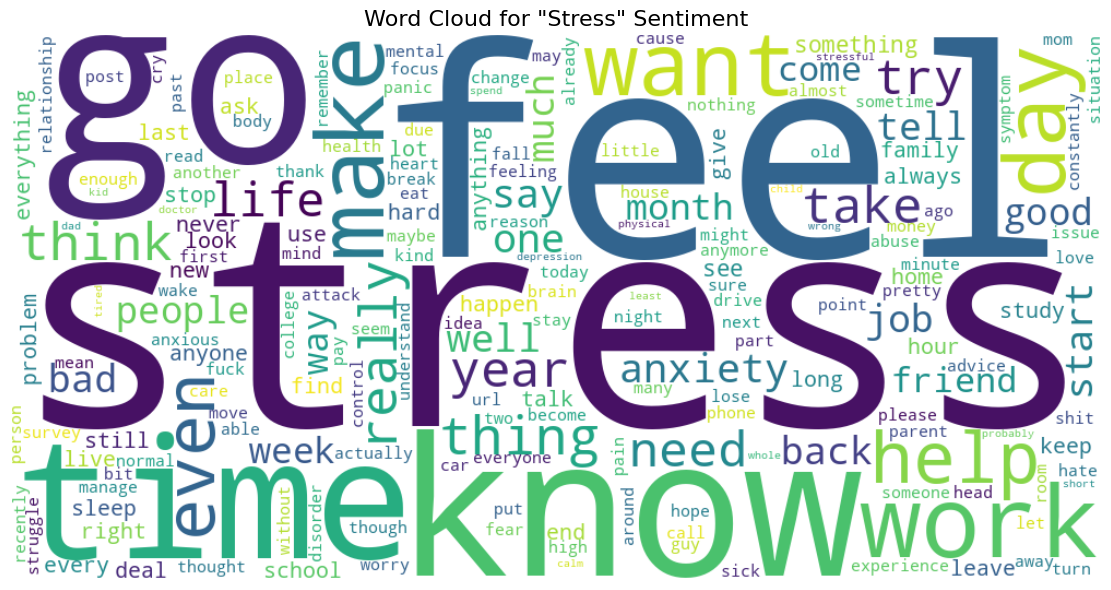

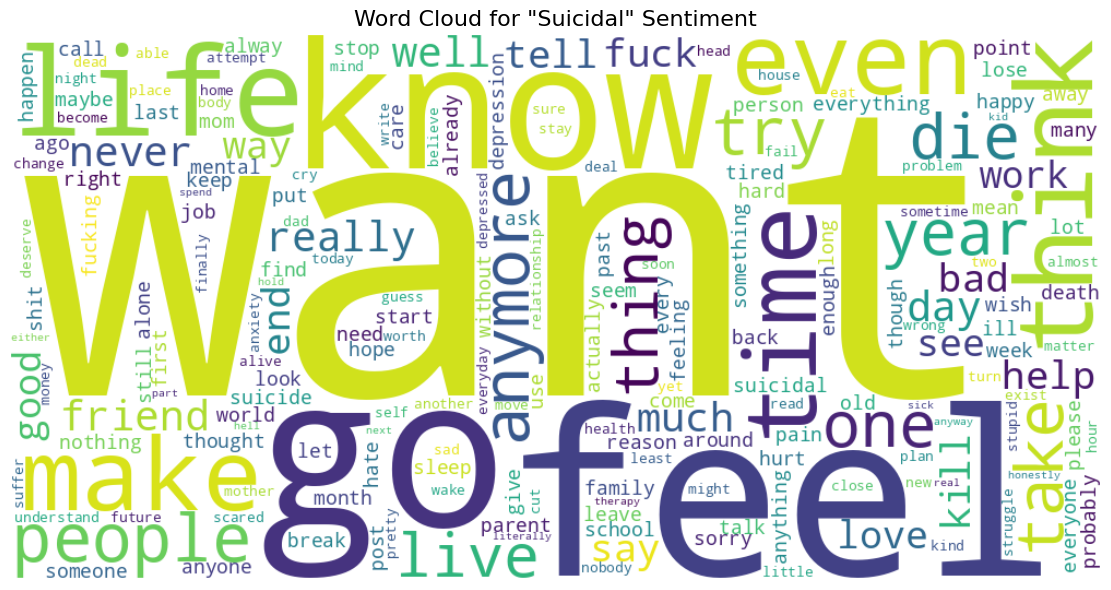

In [21]:
if not X_train_cleaned.empty and not y_train_cleaned.empty:
    print("\n Generating Word Clouds for each sentiment class...")
    temp_df_for_wc = pd.DataFrame({'text': X_train_cleaned, 'label_id': y_train_cleaned})
    for current_label_id, current_label_name in id_to_label.items():
        subset_texts_wc = temp_df_for_wc[temp_df_for_wc['label_id'] == current_label_id]['text']
        if not subset_texts_wc.empty:
            combined_text_wc = " ".join([str(t) for t in subset_texts_wc.tolist() if t and t.strip()])
            if combined_text_wc: # Ensure there's text to generate from
                try:
                    wordcloud_obj = WordCloud(width=1000, height=500, background_color='white',
                                           colormap='viridis', stopwords=None, # Stopwords already removed
                                           collocations=False).generate(combined_text_wc) # Disable collocations for cleaner clouds
                    plt.figure(figsize=(12, 6))
                    plt.imshow(wordcloud_obj, interpolation='bilinear')
                    plt.axis("off")
                    plt.title(f'Word Cloud for "{current_label_name}" Sentiment', fontsize=16)
                    plt.tight_layout()
                    plt.show()
                except ValueError as e_wc: # Catch errors if text is too short or only contains stopwords WordCloud might ignore
                    print(f"Could not generate word cloud for '{current_label_name}': {e_wc}.")
            else:
                print(f"No text content available for word cloud of '{current_label_name}' after combining.")
        else:
            print(f"No samples found for sentiment '{current_label_name}' to generate word cloud.")

# Base Line Model Logistic Regression


 Baseline Model: Logistic Regression
TF-IDF matrix shape for training (Baseline): (35957, 5000)
TF-IDF matrix shape for test (Baseline): (9004, 5000)
Performing GridSearchCV for Logistic Regression with 3 CV splits...
Error during Logistic Regression GridSearchCV: Parameter grid for parameter 'class_weight' needs to be a list or a numpy array, but got 'balanced' (of type str) instead. Single values need to be wrapped in a list with one element.
Attempting to train a default Logistic Regression model as fallback.

 Logistic Regression - Test Set Evaluation:
                      precision    recall  f1-score   support

             Anxiety       0.73      0.78      0.75       713
             Bipolar       0.74      0.76      0.75       556
          Depression       0.75      0.63      0.68      3031
              Normal       0.78      0.90      0.83      1900
Personality disorder       0.48      0.64      0.55       212
              Stress       0.49      0.56      0.52       518
 

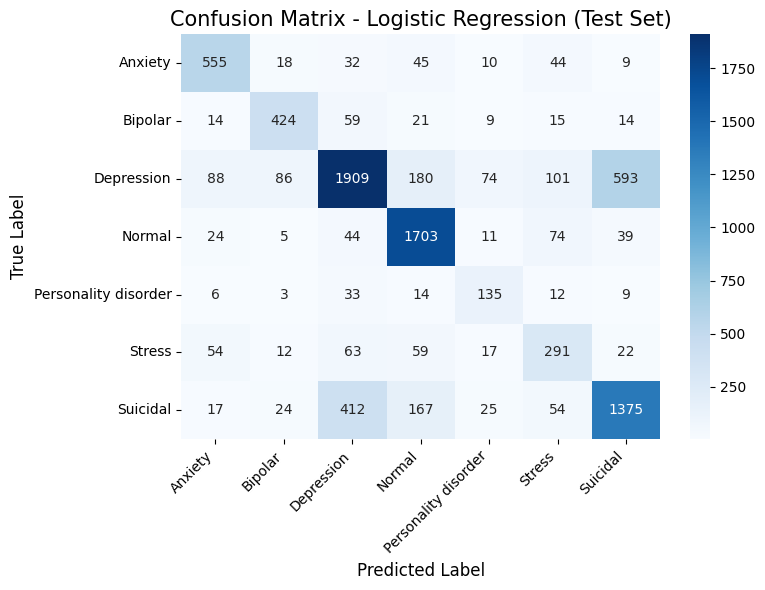

Baseline Model Finished


In [23]:
print("\n Baseline Model: Logistic Regression")
best_lr_model = None # Initialize baseline model variable
if not X_train_cleaned.empty and not y_train_cleaned.empty and len(y_train_cleaned.unique()) > 1:
    # TF-IDF Vectorization
    tfidf_vectorizer_baseline = TfidfVectorizer(
        max_features=MAX_FEATURES_TFIDF,
        min_df=3, # Ignore terms that appear in less than 3 documents
        ngram_range=(1, 2) # Consider both unigrams and bigrams
    )
    # Fit on the cleaned training data (which is already a Series)
    X_train_tfidf_baseline = tfidf_vectorizer_baseline.fit_transform(X_train_cleaned)
    print(f"TF-IDF matrix shape for training (Baseline): {X_train_tfidf_baseline.shape}")

    X_test_tfidf_baseline = None
    if not X_test_cleaned.empty:
        X_test_tfidf_baseline = tfidf_vectorizer_baseline.transform(X_test_cleaned)
        print(f"TF-IDF matrix shape for test (Baseline): {X_test_tfidf_baseline.shape}")
    else:
        print("No cleaned test data available for TF-IDF transformation (Baseline).")

    # Hyperparameter Tuning for Logistic Regression using GridSearchCV
    param_grid_lr = [
        {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 50], 'class_weight': ['balanced', None]},
        {'solver': ['saga'], 'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 50], 'class_weight': ['balanced', None], 'max_iter': [4000]} # saga often needs more iterations
    ]

    min_samples_per_class_lr = y_train_cleaned.value_counts().min()
    cv_splits_lr = min(N_SPLITS_CV_BASELINE, min_samples_per_class_lr if min_samples_per_class_lr is not None and min_samples_per_class_lr > 1 else N_SPLITS_CV_BASELINE)
    if cv_splits_lr < 2: cv_splits_lr = 2 # GridSearchCV requires at least 2 splits

    if X_train_tfidf_baseline.shape[0] >= cv_splits_lr and len(y_train_cleaned.unique()) >= cv_splits_lr :
        print(f"Performing GridSearchCV for Logistic Regression with {cv_splits_lr} CV splits...")

        filtered_param_grid_lr = []
        # Use ParameterGrid to iterate through all combinations
        for p in ParameterGrid(param_grid_lr):
            # liblinear supports l1 and l2
            if p['solver'] == 'liblinear' and p['penalty'] in ['l1', 'l2']:
                filtered_param_grid_lr.append(p)
            # saga supports l1, l2, and elasticnet (elasticnet needs l1_ratio)
            elif p['solver'] == 'saga' and p['penalty'] in ['l1', 'l2']:
                 filtered_param_grid_lr.append(p)
            # Add the case for None class_weight as well, for supported solvers/penalties
            elif p['solver'] in ['liblinear', 'saga'] and p['class_weight'] is None and p['penalty'] in ['l1', 'l2']:
                 filtered_param_grid_lr.append(p)


        # Remove duplicates by converting to frozenset and back to dict
        unique_filtered_param_grid_lr = [dict(s) for s in set(frozenset(d.items()) for d in filtered_param_grid_lr)]

        if not unique_filtered_param_grid_lr: # Fallback if filtering is too aggressive
            print("Warning: Filtered parameter grid for Logistic Regression is empty or invalid. Using original grid.")
            unique_filtered_param_grid_lr = list(ParameterGrid(param_grid_lr)) # Convert to list

        grid_search_lr_obj = GridSearchCV(
            LogisticRegression(max_iter=4000, random_state=42),
            unique_filtered_param_grid_lr, # Use the filtered grid
            cv=KFold(n_splits=cv_splits_lr, shuffle=True, random_state=42),
            scoring='f1_weighted', # F1-score is good for potentially imbalanced classes
            n_jobs=-1, # Use all available cores
            error_score='raise' # Raise errors during CV to catch issues
        )
        try:
            grid_search_lr_obj.fit(X_train_tfidf_baseline, y_train_cleaned)
            best_lr_model = grid_search_lr_obj.best_estimator_
            print(f"Best Logistic Regression Parameters (CV): {grid_search_lr_obj.best_params_}")
            print(f"Best Logistic Regression F1-weighted score (CV): {grid_search_lr_obj.best_score_:.4f}")
        except Exception as e_lr_cv:
            print(f"Error during Logistic Regression GridSearchCV: {e_lr_cv}")
            print("Attempting to train a default Logistic Regression model as fallback.")
            # Fallback model with balanced class weight and a suitable solver
            best_lr_model = LogisticRegression(max_iter=4000, random_state=42, class_weight='balanced', solver='liblinear')
            try:
                 best_lr_model.fit(X_train_tfidf_baseline, y_train_cleaned)
            except Exception as e_fallback:
                 print(f"Error during fallback Logistic Regression training: {e_fallback}")
                 best_lr_model = None # Ensure best_lr_model is None if fallback also fails


    else:
        print("Skipping Logistic Regression GridSearchCV due to insufficient samples/classes for cross-validation.")
        print("Training a default Logistic Regression model instead.")

        best_lr_model = LogisticRegression(max_iter=4000, random_state=42, class_weight='balanced', solver='liblinear')
        try:
             best_lr_model.fit(X_train_tfidf_baseline, y_train_cleaned)
        except Exception as e_default:
             print(f"Error during default Logistic Regression training: {e_default}")
             best_lr_model = None # Ensure best_lr_model is None if default training fails

    # Evaluate Baseline Model on Test Set
    if best_lr_model and X_test_tfidf_baseline is not None and not y_test_cleaned.empty:
        y_pred_lr_test = best_lr_model.predict(X_test_tfidf_baseline)
        print("\n Logistic Regression - Test Set Evaluation:")

        # Get unique labels present in both true and predicted values for the confusion matrix and report
        unique_y_test = sorted(np.unique(y_test_cleaned))
        unique_y_pred_lr_test = sorted(np.unique(y_pred_lr_test))
        all_labels_for_cm = sorted(list(set(unique_y_test + unique_y_pred_lr_test)))
        all_target_names_for_cm = [id_to_label.get(i, str(i)) for i in all_labels_for_cm]


        # Use all_labels_for_cm and all_target_names_for_cm for the classification report as well
        print(classification_report(y_test_cleaned, y_pred_lr_test, labels=all_labels_for_cm, target_names=all_target_names_for_cm, zero_division=0))

        # Confusion Matrix for Baseline Model
        cm_lr_test = confusion_matrix(y_test_cleaned, y_pred_lr_test, labels=all_labels_for_cm)
        plt.figure(figsize=(max(8, len(all_target_names_for_cm)), max(6, len(all_target_names_for_cm)*0.8))) # Dynamic size
        sns.heatmap(cm_lr_test, annot=True, fmt='d', cmap='Blues',
                    xticklabels=all_target_names_for_cm,
                    yticklabels=all_target_names_for_cm)
        plt.title('Confusion Matrix - Logistic Regression (Test Set)', fontsize=15)
        plt.xlabel('Predicted Label', fontsize=12); plt.ylabel('True Label', fontsize=12)
        plt.xticks(fontsize=10, rotation=45, ha='right'); plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()
    elif best_lr_model:
        print("Skipping Logistic Regression test set evaluation: Cleaned test data (TF-IDF) or test labels are unavailable or empty.")
    else:
        print("Skipping Logistic Regression test set evaluation: Model training failed.")

# This 'else' block correctly matches the initial 'if' block
else:
    print("Skipping Logistic Regression training and evaluation: Cleaned training data is empty or has only a single class.")

print("Baseline Model Finished")

# Advance Transformer Model RoBERTa

In [28]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, RobertaConfig



 Advanced Model: roberta-base with Regularization
Preparing data for roberta-base...
DL actual training set size: 32361, DL validation set size: 3596
Initializing roberta-base with custom dropout rate: 0.2 and target weight decay: 0.01


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Using class weights for roberta-base training loss: [1.79394645 2.31961867 0.42308044 0.68743494 5.98059508 2.48949919
 0.61566121]
Total training steps: 14161, Warmup steps: 1416

Re-confirming Start of roberta-base Model Training with Regularization...

Epoch 1/7


Training: Loss = 1.2889, Accuracy = 0.5134


Validation: Loss = 0.9409, Accuracy = 0.6655
Validation accuracy improved (-1.0000 --> 0.6655). Saving model to '/content/roberta-base_best_model_reg'

Epoch 2/7


Training: Loss = 0.8560, Accuracy = 0.6846


Validation: Loss = 0.7634, Accuracy = 0.7116
Validation accuracy improved (0.6655 --> 0.7116). Saving model to '/content/roberta-base_best_model_reg'

Epoch 3/7


Training: Loss = 0.7248, Accuracy = 0.7263


Validation: Loss = 0.7366, Accuracy = 0.7225
Validation accuracy improved (0.7116 --> 0.7225). Saving model to '/content/roberta-base_best_model_reg'

Epoch 4/7


Training: Loss = 0.6356, Accuracy = 0.7505


Validation: Loss = 0.7997, Accuracy = 0.7125
Validation accuracy did not improve for 1 epoch(s).

Epoch 5/7


Training: Loss = 0.5567, Accuracy = 0.7711


Validation: Loss = 0.7288, Accuracy = 0.7314
Validation accuracy improved (0.7225 --> 0.7314). Saving model to '/content/roberta-base_best_model_reg'

Epoch 6/7


Training: Loss = 0.4958, Accuracy = 0.7912


Validation: Loss = 0.7060, Accuracy = 0.7525
Validation accuracy improved (0.7314 --> 0.7525). Saving model to '/content/roberta-base_best_model_reg'

Epoch 7/7


Training: Loss = 0.4436, Accuracy = 0.8043


Validation: Loss = 0.7265, Accuracy = 0.7461
Validation accuracy did not improve for 1 epoch(s).

roberta-base training finished.
Best validation accuracy achieved during training: 0.7525


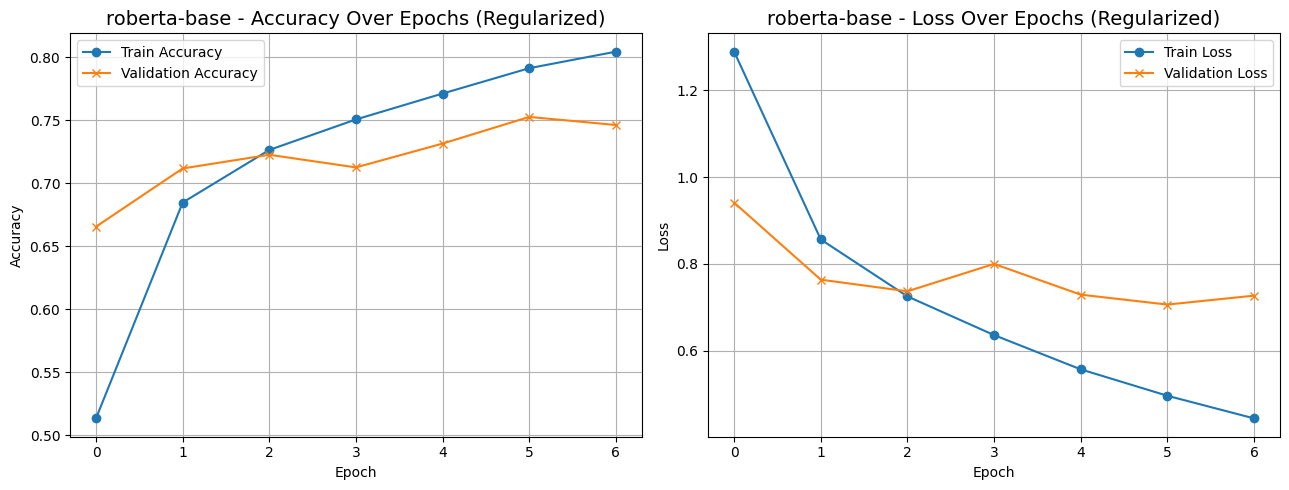


Loading best saved roberta-base model from '/content/roberta-base_best_model_reg' for final test set evaluation...

Evaluating roberta-base (best validation model) on the Test Set...


roberta-base Final Test Loss: 0.7235, Final Test Accuracy: 0.7548

 Classification Report (Test Set):
                      precision    recall  f1-score   support

             Anxiety       0.81      0.81      0.81       713
             Bipolar       0.84      0.78      0.81       556
          Depression       0.74      0.71      0.72      3031
              Normal       0.93      0.86      0.89      1900
Personality disorder       0.67      0.60      0.63       212
              Stress       0.60      0.70      0.65       518
            Suicidal       0.66      0.73      0.69      2074

            accuracy                           0.75      9004
           macro avg       0.75      0.74      0.74      9004
        weighted avg       0.76      0.75      0.76      9004



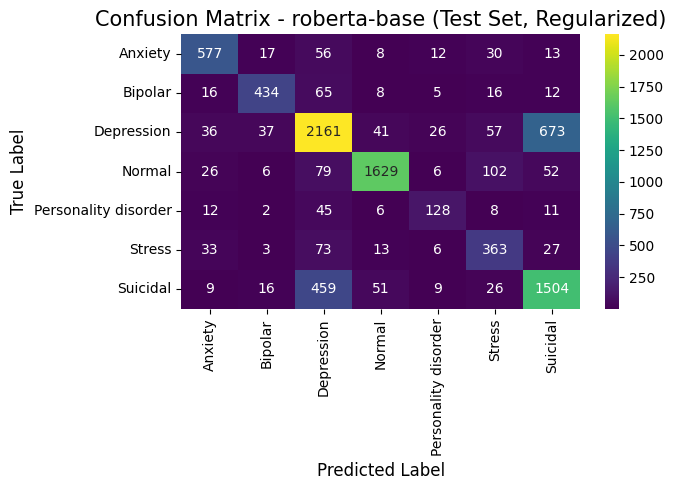

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import sys
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR = "/content"

class SentimentDLDataset(Dataset):
    def __init__(self, texts_list, int_labels_list, tokenizer_instance, max_seq_len):
        self.texts = texts_list
        self.labels = int_labels_list
        self.tokenizer = tokenizer_instance
        self.max_len = max_seq_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text_item = str(self.texts[idx])
        label_item = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text_item,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label_item, dtype=torch.long)
        }

def train_epoch_dl_model(model_instance, dl_data_loader, loss_function, dl_optimizer, torch_device, dl_scheduler, num_examples):
    model_instance.train()
    total_epoch_loss = 0
    correct_epoch_predictions = 0
    for batch in tqdm(dl_data_loader, desc=f"Training DL Epoch", leave=False):
        b_input_ids = batch["input_ids"].to(torch_device)
        b_attention_mask = batch["attention_mask"].to(torch_device)
        b_labels = batch["labels"].to(torch_device)

        dl_optimizer.zero_grad()
        outputs = model_instance(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)

        loss = loss_function(outputs.logits, b_labels)

        total_epoch_loss += loss.item() * b_input_ids.size(0)

        preds = torch.argmax(outputs.logits, dim=1)
        correct_epoch_predictions += torch.sum(preds == b_labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_instance.parameters(), max_norm=1.0)
        dl_optimizer.step()
        if dl_scheduler:
            dl_scheduler.step()

    avg_epoch_loss = total_epoch_loss / num_examples
    epoch_accuracy = correct_epoch_predictions.double() / num_examples
    return epoch_accuracy, avg_epoch_loss

def eval_dl_model(model_instance, dl_data_loader, torch_device, num_examples, loss_function_eval=None):
    model_instance.eval()
    total_eval_loss = 0
    correct_eval_predictions = 0
    all_eval_preds = []
    all_eval_labels = []
    with torch.no_grad():
        for batch in tqdm(dl_data_loader, desc=f"Evaluating DL", leave=False):
            b_input_ids = batch["input_ids"].to(torch_device)
            b_attention_mask = batch["attention_mask"].to(torch_device)
            b_labels = batch["labels"].to(torch_device)

            outputs = model_instance(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)

            if loss_function_eval:
                 loss = loss_function_eval(outputs.logits, b_labels)
            else:
                 loss = outputs.loss

            total_eval_loss += loss.item() * b_input_ids.size(0)

            preds = torch.argmax(outputs.logits, dim=1)
            correct_eval_predictions += torch.sum(preds == b_labels)
            all_eval_preds.extend(preds.cpu().numpy())
            all_eval_labels.extend(b_labels.cpu().numpy())

    avg_eval_loss = total_eval_loss / num_examples
    eval_accuracy = correct_eval_predictions.double() / num_examples
    return eval_accuracy, avg_eval_loss, all_eval_preds, all_eval_labels

print(f"\n Advanced Model: {MODEL_NAME_DL} with Regularization")
train_dataloader_dl_actual, val_dataloader_dl, test_dataloader_dl_final = None, None, None
roberta_model, roberta_tokenizer = None, None
model_loaded_for_final_test = None
loss_fn_dl_model_train, loss_fn_dl_model_eval = None, None

if not X_train_cleaned.empty and not y_train_cleaned.empty and len(y_train_cleaned.unique()) > 1:
    print(f"Preparing data for {MODEL_NAME_DL}...")

    try:
        roberta_tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME_DL)
    except Exception as e:
        print(f"Error initializing tokenizer {MODEL_NAME_DL}: {e}")
        roberta_tokenizer = None

    if roberta_tokenizer is not None:
        X_train_cleaned_list_dl = X_train_cleaned.tolist()
        y_train_cleaned_list_dl = y_train_cleaned.tolist()

        try:
            X_train_dl_actual_texts, X_val_dl_texts, y_train_dl_actual_labels, y_val_dl_labels = train_test_split(
                X_train_cleaned_list_dl, y_train_cleaned_list_dl,
                test_size=VALIDATION_SPLIT_SIZE, random_state=42, stratify=y_train_cleaned_list_dl
            )
        except ValueError:
            print("Warning: Stratification failed for DL train/validation split. Proceeding without.")
            X_train_dl_actual_texts, X_val_dl_texts, y_train_dl_actual_labels, y_val_dl_labels = train_test_split(
                X_train_cleaned_list_dl, y_train_cleaned_list_dl,
                test_size=VALIDATION_SPLIT_SIZE, random_state=42
            )
        print(f"DL actual training set size: {len(X_train_dl_actual_texts)}, DL validation set size: {len(X_val_dl_texts)}")

        train_dataset_dl_actual = SentimentDLDataset(X_train_dl_actual_texts, y_train_dl_actual_labels, roberta_tokenizer, MAX_LEN_DL)
        train_dataloader_dl_actual = DataLoader(train_dataset_dl_actual, batch_size=BATCH_SIZE_DL, shuffle=True, num_workers=0)

        if X_val_dl_texts and len(X_val_dl_texts) > 0:
            val_dataset_dl = SentimentDLDataset(X_val_dl_texts, y_val_dl_labels, roberta_tokenizer, MAX_LEN_DL)
            val_dataloader_dl = DataLoader(val_dataset_dl, batch_size=BATCH_SIZE_DL, num_workers=0)
        else:
             print("No validation data created or validation set is empty.")
             val_dataset_dl = None
             val_dataloader_dl = None

        if not X_test_cleaned.empty and not y_test_cleaned.empty:
            test_dataset_dl_final = SentimentDLDataset(X_test_cleaned.tolist(), y_test_cleaned.tolist(), roberta_tokenizer, MAX_LEN_DL)
            test_dataloader_dl_final = DataLoader(test_dataset_dl_final, batch_size=BATCH_SIZE_DL, num_workers=0)
        else:
            print(f"No cleaned test data available for {MODEL_NAME_DL} model evaluation.")
            test_dataset_dl_final = None
            test_dataloader_dl_final = None

        if roberta_model is None:
            print(f"Initializing {MODEL_NAME_DL} with custom dropout rate: {DROPOUT_RATE_DL} and target weight decay: {WEIGHT_DECAY_DL}")

            try:
                config_dl = RobertaConfig.from_pretrained(
                    MODEL_NAME_DL,
                    num_labels=len(unique_labels),
                    id2label=id_to_label,
                    label2id=label_map,
                    hidden_dropout_prob=DROPOUT_RATE_DL,
                    attention_probs_dropout_prob=DROPOUT_RATE_DL
                )
            except Exception as e:
                print(f"Error loading {MODEL_NAME_DL} config: {e}")
                config_dl = None

            if config_dl is not None:
                try:
                    roberta_model = RobertaForSequenceClassification.from_pretrained(
                        MODEL_NAME_DL,
                        config=config_dl
                    ).to(device)
                except Exception as e:
                     print(f"Error initializing {MODEL_NAME_DL} model: {e}")
                     roberta_model = None
            else:
                 roberta_model = None

            if roberta_model is not None:
                loss_fn_dl_model_train = None
                loss_fn_dl_model_eval = None

                if len(np.unique(y_train_dl_actual_labels)) > 1:
                    try:
                        class_weights_values_dl = compute_class_weight(
                            'balanced',
                            classes=np.unique(y_train_dl_actual_labels),
                            y=y_train_dl_actual_labels
                        )
                        class_weights_tensor_dl = torch.tensor(class_weights_values_dl, dtype=torch.float).to(device)
                        loss_fn_dl_model_train = nn.CrossEntropyLoss(weight=class_weights_tensor_dl).to(device)
                        loss_fn_dl_model_eval = nn.CrossEntropyLoss().to(device)
                        print(f"Using class weights for {MODEL_NAME_DL} training loss: {class_weights_values_dl}")
                    except Exception as e:
                         print(f"Error computing or setting class weights: {e}. Using standard CrossEntropyLoss.")
                         loss_fn_dl_model_train = nn.CrossEntropyLoss().to(device)
                         loss_fn_dl_model_eval = nn.CrossEntropyLoss().to(device)
                else:
                    loss_fn_dl_model_train = nn.CrossEntropyLoss().to(device)
                    loss_fn_dl_model_eval = nn.CrossEntropyLoss().to(device)
                    print(f"Using standard CrossEntropyLoss for {MODEL_NAME_DL} (single class or no weights computed).")

                optimizer_dl_model = AdamW(
                    roberta_model.parameters(),
                    lr=LEARNING_RATE_DL,
                    eps=1e-8,
                    weight_decay=WEIGHT_DECAY_DL
                )

                if train_dataloader_dl_actual is not None and len(train_dataset_dl_actual) > 0:
                    total_training_steps_dl = len(train_dataloader_dl_actual) * EPOCHS_DL
                    num_warmup_steps_dl = int(total_training_steps_dl * 0.10) if total_training_steps_dl > 0 else 0

                    scheduler_dl_model = get_linear_schedule_with_warmup(
                        optimizer_dl_model,
                        num_warmup_steps=num_warmup_steps_dl,
                        num_training_steps=total_training_steps_dl
                    )
                    print(f"Total training steps: {total_training_steps_dl}, Warmup steps: {num_warmup_steps_dl}")
                else:
                    print("Error: train_dataloader_dl_actual not defined or empty. Cannot create scheduler.")
                    scheduler_dl_model = None
            else:
                print("Skipping optimizer and scheduler setup as model initialization failed.")
                optimizer_dl_model = None
                scheduler_dl_model = None
        else:
             print(f"{MODEL_NAME_DL} model already initialized.")
    else:
         print(f"Skipping data preparation and model setup for {MODEL_NAME_DL} due to tokenizer initialization failure.")
else:
    print(f"Skipping {MODEL_NAME_DL} model setup: Cleaned training data is empty or has only a single class.")

if roberta_model is not None and train_dataloader_dl_actual is not None and optimizer_dl_model is not None and scheduler_dl_model is not None and loss_fn_dl_model_train is not None:
    print(f"\nRe-confirming Start of {MODEL_NAME_DL} Model Training with Regularization...")
    training_history_dl = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
    best_validation_accuracy_dl = -1.0
    epochs_without_improvement_dl = 0
    best_dl_model_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME_DL.replace("/", "-")}_best_model_reg')
    os.makedirs(best_dl_model_path, exist_ok=True)

    has_validation_set = val_dataloader_dl is not None and val_dataset_dl is not None and len(val_dataset_dl) > 0

    for epoch_i in range(EPOCHS_DL):
        print(f"\nEpoch {epoch_i + 1}/{EPOCHS_DL}")
        epoch_train_acc, epoch_train_loss = train_epoch_dl_model(
            roberta_model,
            train_dataloader_dl_actual,
            loss_fn_dl_model_train,
            optimizer_dl_model,
            device,
            scheduler_dl_model,
            len(train_dataset_dl_actual)
        )
        training_history_dl['train_acc'].append(epoch_train_acc.item() if torch.is_tensor(epoch_train_acc) else epoch_train_acc)
        training_history_dl['train_loss'].append(epoch_train_loss)
        print(f"Training: Loss = {epoch_train_loss:.4f}, Accuracy = {epoch_train_acc:.4f}")

        if has_validation_set:
            epoch_val_acc, epoch_val_loss, _, _ = eval_dl_model(
                roberta_model,
                val_dataloader_dl,
                device,
                len(val_dataset_dl),
                loss_function_eval=loss_fn_dl_model_eval
            )
            training_history_dl['val_acc'].append(epoch_val_acc.item() if torch.is_tensor(epoch_val_acc) else epoch_val_acc)
            training_history_dl['val_loss'].append(epoch_val_loss)
            print(f"Validation: Loss = {epoch_val_loss:.4f}, Accuracy = {epoch_val_acc:.4f}")

            if epoch_val_acc > best_validation_accuracy_dl:
                print(f"Validation accuracy improved ({best_validation_accuracy_dl:.4f} --> {epoch_val_acc:.4f}). Saving model to '{best_dl_model_path}'")
                roberta_model.save_pretrained(best_dl_model_path)
                if roberta_tokenizer:
                    roberta_tokenizer.save_pretrained(best_dl_model_path)
                else:
                     print("Warning: Tokenizer not initialized, skipping saving tokenizer.")

                best_validation_accuracy_dl = epoch_val_acc
                epochs_without_improvement_dl = 0
            else:
                epochs_without_improvement_dl += 1
                print(f"Validation accuracy did not improve for {epochs_without_improvement_dl} epoch(s).")

            if epochs_without_improvement_dl >= PATIENCE_EPOCHS:
                print(f"Early stopping triggered after {PATIENCE_EPOCHS} epochs without validation accuracy improvement.")
                break

        elif epoch_i == EPOCHS_DL - 1:
             print(f"No validation set provided. Saving final model from epoch {epoch_i + 1} to '{best_dl_model_path}'")
             roberta_model.save_pretrained(best_dl_model_path)
             if roberta_tokenizer:
                roberta_tokenizer.save_pretrained(best_dl_model_path)
             else:
                print("Warning: Tokenizer not initialized, skipping saving tokenizer.")

    print(f"\n{MODEL_NAME_DL} training finished.")
    if has_validation_set and best_validation_accuracy_dl > -1.0:
        print(f"Best validation accuracy achieved during training: {best_validation_accuracy_dl:.4f}")
    elif not has_validation_set:
        print("No validation set provided during training.")

    if training_history_dl['train_acc']:
        plt.figure(figsize=(13, 5))
        plt.subplot(1, 2, 1)
        plt.plot(training_history_dl['train_acc'], label='Train Accuracy', marker='o')
        if has_validation_set and training_history_dl['val_acc']:
            plt.plot(training_history_dl['val_acc'], label='Validation Accuracy', marker='x')
        plt.title(f'{MODEL_NAME_DL} - Accuracy Over Epochs (Regularized)', fontsize=14); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(training_history_dl['train_loss'], label='Train Loss', marker='o')
        if has_validation_set and training_history_dl['val_loss']:
            plt.plot(training_history_dl['val_loss'], label='Validation Loss', marker='x')
        plt.title(f'{MODEL_NAME_DL} - Loss Over Epochs (Regularized)', fontsize=14); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'{MODEL_NAME_DL.replace("/", "-")}_training_history_reg.png'))
        plt.show()
    else:
        print("No training history recorded to plot.")
else:
    print(f"Skipping {MODEL_NAME_DL} model training: Necessary components (model, data, optimizer, scheduler, loss) not initialized.")

model_loaded_for_final_test = None
best_dl_model_path_to_load = os.path.join(OUTPUT_DIR, f'{MODEL_NAME_DL.replace("/", "-")}_best_model_reg')

if os.path.exists(best_dl_model_path_to_load):
    print(f"\nLoading best saved {MODEL_NAME_DL} model from '{best_dl_model_path_to_load}' for final test set evaluation...")
    try:
        loaded_tokenizer = RobertaTokenizerFast.from_pretrained(best_dl_model_path_to_load)
        model_loaded_for_final_test = RobertaForSequenceClassification.from_pretrained(best_dl_model_path_to_load).to(device)

        roberta_tokenizer = loaded_tokenizer

        if loss_fn_dl_model_eval is None:
             print("Warning: Evaluation loss function was not initialized during setup. Creating a default CrossEntropyLoss for evaluation.")
             loss_fn_dl_model_eval = nn.CrossEntropyLoss().to(device)

    except Exception as e_load_best_dl:
        print(f"Error loading best DL model from '{best_dl_model_path_to_load}': {e_load_best_dl}")
        model_loaded_for_final_test = None
        roberta_tokenizer = None

else:
    print(f"Best DL model path '{best_dl_model_path_to_load}' not found. Cannot evaluate on test set.")
    model_loaded_for_final_test = None

if model_loaded_for_final_test is not None and test_dataloader_dl_final is not None and loss_fn_dl_model_eval is not None:
    print(f"\nEvaluating {MODEL_NAME_DL} (best validation model) on the Test Set...")

    if 'test_dataset_dl_final' in locals() and test_dataset_dl_final is not None:
        num_test_examples = len(test_dataset_dl_final)
    else:
        print("Error: test_dataset_dl_final not available. Cannot get number of test examples.")
        num_test_examples = 0

    if num_test_examples > 0:
        final_test_acc_dl, final_test_loss_dl, y_pred_dl_final_test, y_true_dl_final_test = eval_dl_model(
            model_loaded_for_final_test,
            test_dataloader_dl_final,
            device,
            num_test_examples,
            loss_function_eval=loss_fn_dl_model_eval
        )
        print(f"{MODEL_NAME_DL} Final Test Loss: {final_test_loss_dl:.4f}, Final Test Accuracy: {final_test_acc_dl:.4f}")

        report_labels_dl_final = sorted(list(set(y_true_dl_final_test) | set(y_pred_dl_final_test)))
        if 'id_to_label' in globals():
            report_target_names_dl_final = [id_to_label.get(i, str(i)) for i in report_labels_dl_final]
        else:
            print("Warning: id_to_label mapping not available. Using integer labels for report and matrix.")
            report_target_names_dl_final = [str(i) for i in report_labels_dl_final]

        print("\n Classification Report (Test Set):")
        print(classification_report(y_true_dl_final_test, y_pred_dl_final_test, labels=report_labels_dl_final, target_names=report_target_names_dl_final, zero_division=0))

        cm_dl_final = confusion_matrix(y_true_dl_final_test, y_pred_dl_final_test, labels=report_labels_dl_final)
        plt.figure(figsize=(max(6, len(report_target_names_dl_final)), max(5, len(report_target_names_dl_final)*0.7)))
        sns.heatmap(cm_dl_final, annot=True, fmt='d', cmap='viridis',
                    xticklabels=report_target_names_dl_final, yticklabels=report_target_names_dl_final)
        plt.title(f'Confusion Matrix - {MODEL_NAME_DL} (Test Set, Regularized)', fontsize=15)
        plt.xlabel('Predicted Label', fontsize=12); plt.ylabel('True Label', fontsize=12)
        plt.xticks(fontsize=10); plt.yticks(fontsize=10); plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'{MODEL_NAME_DL.replace("/", "-")}_confusion_matrix_test_reg.png'))
        plt.show()
    else:
        print("Skipping test set evaluation: No test examples available.")
else:
    print(f"Skipping {MODEL_NAME_DL} final test set evaluation: Best model not loaded, no final test data/loader, or evaluation loss function is missing.")
